In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch
from torch import nn
import torch.nn.functional as f

from utils import flat_to_triangular, make_cholesky, plot, clean_curr_axes, onehot, log_sum_exp

np.random.seed(3)

### $N$-dimensional features, scalar regression target, with covariance

### Problem

We consider a egression problem with N-dimensional features $x$, scalar targets $t$ and known variance $\sigma^2$ We wish to learn a bayesian linear model with learnt basis functions. 

### Case of the known basis function

In the case of a known deterministic N-dimensional basis function $\phi$, le likelihood is expressed as:

\begin{align}
p(t | a, b, x, \sigma) & = \mathcal{N}(a \phi(x) + b, \sigma^2) 
\end{align}

We define the prior over the parameters as an isotropic Gaussian, which gives:

\begin{align}
 p(a) = \mathcal{N}(0,1) \qquad  p(b) = \mathcal{N}(0,1)
\end{align}

It is then possible to compute the posterior of parameters analytically, given $(\mathbf{x}, \mathbf{t})$ the entire dataset:

\begin{align}
p(a,b |\mathbf{t} , \mathbf{x}, \sigma^2) = \frac{p(\mathbf{t} | a, b, \mathbf{x}, \sigma^2) p(a,b)}{p(\mathbf{t}, \mathbf{x})}
\end{align}

$p(\mathbf{t})$ is tractable and constant, hence we can also approximate the posterior using our favorite MCMC methods.


### Learnt basis function

#### Bayes by Backprop

We propose to optimize $\theta$ using maximum likelihood and $a, b$ using Variational Inference, which allows us deriving a lower bound of the marginal log likelihood (with regards to $a,b$) that we can optimize end-to-end. We have:

\begin{align}
\log p(\mathbf{t} | \mathbf{x}, \sigma^2, \theta) & = \log \int_{a,b} \log p(\mathbf{t}, a, b, | \mathbf{x}, \sigma^2, \theta) dadb \\
& = \log \int_{a,b} \log p(\mathbf{t} | a, b, \mathbf{x}, \sigma^2, \theta)p(a,b) dadb \\
& = \log \int_{a,b} q(a,b) p(\mathbf{t} | a, b, \mathbf{x}, \sigma^2, \theta) \frac{p(a,b)}{q(a,b)} dadb \\
& \geq \mathbb{E}_{q(a,b)} \left[ \log  p(\mathbf{t} | a, b, \mathbf{t}, \sigma^2, \theta) \frac{p(a,b)}{q(a,b)} \right] \\
& = \mathbb{E}_q[\log p_{\theta}(\mathbf{t}\ |\ a, b, \mathbf{x})] - \mathrm{KL}(q(a,b) \ ||\ p(a,b)) \\
& = \mathcal{L_(t, x)}
\end{align}

#### Modelling the posterior of vector quantities with covariance

In this context, $a$ is a vector of size $N$ and $b$ a scalar. We write $v$ the vector representing all the parameters ${a_i}_a + b$. In this context, we choose to model the approximate posterior of $v$ using a **Multivariate Gaussian** parametrized by a Cholesky factor $L$, which allows us to apply the reparametrization trick [[Pathwise Derivatives Beyond the Reparameterization Trick]](https://arxiv.org/pdf/1806.01851.pdf):

\begin{align}
y \sim \mathcal{N}(\mu, L) \\
y = \mu + L \epsilon \\
\epsilon \sim \mathcal{N}(\mu, I)
\end{align}

The covariance matrix is then defined as:

\begin{aligned} \boldsymbol{\Sigma} &=\mathbb{E}\left[(\mathbf{z}-\mathbb{E}[\mathbf{z} |])(\mathbf{z}-\mathbb{E}[\mathbf{z} |])^{T}\right] \\ &=\mathbb{E}\left[\mathbf{L} \boldsymbol{\epsilon}(\mathbf{L} \boldsymbol{\epsilon})^{T}\right] \\ &=\mathbb{E}\left[\mathbf{L} \boldsymbol{\epsilon} \boldsymbol{\epsilon}^{T} \mathbf{L}^{T}\right] \\ &=\mathbf{L} \mathbb{E}\left[\boldsymbol{\epsilon} \boldsymbol{\epsilon}^{T}\right] \mathbf{L}^{T} \\ &=\mathbf{L} \mathbf{L}^{T} \end{aligned}


We can then write our ELBO as:

\begin{split}
\mathbb{E}_q[\log p_{\theta}(\mathbf{t}\ |\ a, b, \mathbf{x})] =  \mathbb{E}_q \left[ \sum_{x \in \mathbf{x}} \left[ -\frac{1}{2} \log \sigma^2 - \frac{1}{2\sigma^2} [(t - a f_{\theta}(x) - b)^2] + \mathrm{const.} \right] \right] \\
\mathrm{KL}(q(v) \ ||\ p(v)) = -\frac{1}{2} \sum_{i=1}^d \left(1 + \log L_{i,i}^2 - \mu_i^2 - L_{i,i}^2\right)
\end{split}

**TODO: check if KL correct**

AD: Actually I think it is like this:
$$ -\frac{1}{2} \sum_{i=1}^d \left(1 + \log L_{i,i}^2 - \mu_i^2 - \Sigma_{i,i}\right) $$
so the last term is the variances (diagonal of $\boldsymbol{\Sigma}$, because the diagonal of $\mathbf{L}$ is not the stds)


### Papers

[Gaussian variational approximation with a factor covariance structure](https://arxiv.org/pdf/1701.03208.pdf)

[Pathwise Derivatives Beyond the Reparameterization Trick](https://arxiv.org/pdf/1806.01851.pdf)

[Berkley Kingma ppt](https://berkeley-deep-learning.github.io/cs294-131-s17/slides/VAE%20talk.compressed.pdf)

### Toy Dataset

Take $N$ random points in $[-1, 1]$, compute some function of the points and add noise, finally divide the data in $K=3$ classes of equal size.

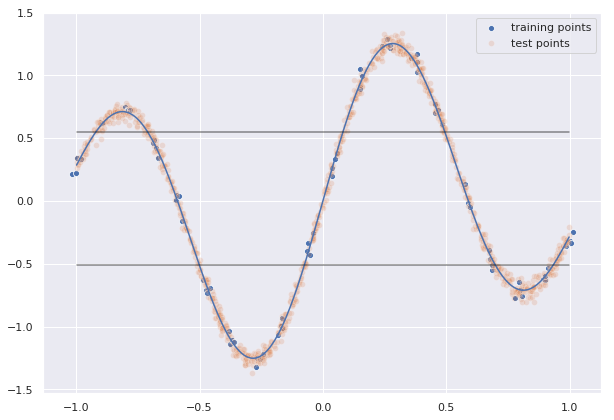

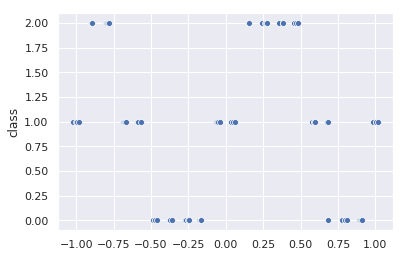

x shape: (80, 1)
x test shape: (1000, 1)
t shape: (80, 3)
t_values shape: (80,)


In [2]:
N = 80    # data points
duplicate_factor = 4
duplicate_sigma = 0.01
N_test = 1000  # test data points
sigma = .04  # final noise
n_classes = 3

## Random data points
# x = np.random.rand(N + N_test, 1) * 2 - 1

## Random clusters of data points
x = np.linspace(-1.0, 1.0, N//duplicate_factor).reshape(-1, 1)
# x = np.random.rand(N//duplicate_factor, 1) * 2 - 1
noise = np.random.randn(N//duplicate_factor, duplicate_factor) * duplicate_sigma
x = x + noise
x = x.reshape(N, 1)

x_test = np.random.rand(N_test, 1) * 2 - 1

x = np.concatenate((x_test, x), axis=0)

fx = -x**3 + x + np.sin(6 * x)
noisy_fx = fx + sigma*np.random.randn(*x.shape)  # function to compute labels

# Divide data interval in n_classes regions
# thresholds = np.linspace(tmp.min() - 1e-3, tmp.max() + 1e-3, n_classes+1)  # equal size
thresholds = np.percentile(noisy_fx, np.linspace(0, 100, n_classes+1))  # balanced classes

# targets
t = np.zeros((noisy_fx.shape[0], n_classes), dtype=int)  # one-hot, shape (N, C)
for i in range(n_classes):
    t[:, i] = ((thresholds[i] < noisy_fx) * (thresholds[i+1] >= noisy_fx))[:, 0]
t_values = t * np.arange(n_classes).reshape((1, -1))
t_values = np.sum(t_values, 1)

x_test = x[:N_test]
x = x[N_test:]
fx_test = fx[:N_test]
fx = fx[N_test:]
noisy_fx_test = noisy_fx[:N_test]
noisy_fx = noisy_fx[N_test:]
t_test = t[:N_test]
t = t[N_test:]
t_values_test = t_values[:N_test]
t_values = t_values[N_test:]

test_sort_idx = np.argsort(x_test, axis=0).flatten()
x_test, fx_test, noisy_fx_test, t_test, t_values_test = (
    tensor[test_sort_idx] for tensor in [x_test, fx_test, noisy_fx_test, t_test, t_values_test])
sort_idx = np.argsort(x, axis=0).flatten()
x, fx, noisy_fx, t, t_values = (tensor[sort_idx] for tensor in [x, fx, noisy_fx, t, t_values])


# Plot continuous data and class thresholds
plt.figure(figsize=(10, 7))
plt.plot(x_test, fx_test)
sns.scatterplot(x[:, 0], noisy_fx[:, 0], label='training points')
sns.scatterplot(x_test[:, 0], noisy_fx_test[:, 0], alpha=0.2, label='test points')
for i in range(1, n_classes):
    plt.plot([x_test[0], x_test[-1]], np.array([1., 1.]) * thresholds[i], color='k', alpha=0.5)
plt.legend()
plt.show()

# Plot class distribution
sns.scatterplot(x[:, 0], t_values)
plt.ylabel('class')
plt.show()


# # Plot continuous data and class thresholds: test data
# plt.figure(figsize=(10, 7))
# plt.plot(x_test, fx_test)
# sns.scatterplot(x_test[:, 0], noisy_fx_test[:, 0])
# for i in range(1, n_classes):
#     plt.plot([x_test[0], x_test[-1]], np.array([1., 1.]) * thresholds[i], color='k', alpha=0.5)
# plt.show()



print('x shape:', x.shape)
print('x test shape:', x_test.shape)

print('t shape:', t.shape)
print('t_values shape:', t_values.shape)

x = torch.tensor(x, dtype=torch.float)
t_values = torch.tensor(t_values, dtype=torch.long)
x_test = torch.tensor(x_test, dtype=torch.float)
t_values_test = torch.tensor(t_values_test, dtype=torch.long)

### Features extractor and stochastic layer

Define function $f_{\theta}$ to extract features $\mathbf{h} = f_{\theta}(x)$, with parameters $\theta$ to be optimized. The features $\mathbf{h}$ have size $m$, the weight matrix $\mathbf{a}$ has shape $m \times k$, the bias $\mathbf{b}$ has size $k$, and $k$ is the number of classes. Logits are $\mathbf{h \cdot a} + \mathbf{b}$, with $\mathbf{a}$ and $\mathbf{b}$ multivariate Normal rvs with full covariance (including correlation between $\mathbf{a}$ and $\mathbf{b}$).

The stochastic layer has no state, it's only used to get samples from $\mathcal{N}(\mu, \Sigma)$, and to compute the KL divergence from a prior $\mathcal{N}(0, I)$ to a variational distribution $q = \mathcal{N}(\mu, \Sigma)$.

In [3]:
last_layer_size = 48
a_shape = (last_layer_size, n_classes)  # shape of stochastic weight matrix
a_size = np.prod(a_shape)
b_size = n_classes

class FeaturesExtractor(nn.Module):
    def __init__(self, n_out, use_dropout=False):
        super().__init__()
        if use_dropout:
            self.layers = nn.Sequential(
                nn.Linear(1, 64), nn.LeakyReLU(),
                nn.Dropout(0.4),
                nn.Linear(64, 64), nn.LeakyReLU(),
                nn.Dropout(0.4),
                nn.Linear(64, n_out))
        else:
            self.layers = nn.Sequential(
                nn.Linear(1, 32), nn.LeakyReLU(),
                nn.Linear(32, n_out))
        
    def forward(self, x):
        return self.layers(x)
    
    
class CovarianceStochasticLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, mu_q, cholesky):
        eps = torch.randn_like(mu_q)
        return mu_q + cholesky @ eps
    
    def forward_diagonal(self, mu_q, logvar_q):
        eps = torch.randn_like(mu_q)
        std = (logvar_q/2).exp()
        return mu_q + std * eps

    # def get_kl(self, mu_q, logvar_q):
    #     kl = -0.5 * (1 + logvar_q - mu_q.pow(2) - logvar_q.exp())
    #     return kl.sum()
    def get_kl(self, mu_q, L_logdiag_q, L_q):
        kl = -0.5 * (1 + L_logdiag_q - mu_q.pow(2) - torch.diag(L_q @ L_q.permute(1, 0)))
        #print(L_logdiag_q.sum().item(), mu_q.pow(2).sum().item(), torch.diag(L_q @ L_q.permute(1, 0)).sum().item())
        return kl.sum()


### Optimize

Here we maximize the ELBO $\mathcal{L}$ with respect to variational parameters $\mu_a, \sigma_a, \mu_b, \sigma_b$, the NN parameters $\theta$, and the noise std $\sigma$.

First train model with ML (no sampling, just train means), then compare with the Bayesian one.

Things that seem to be important for the Bayesian model:
- large last layer: with many parameters, we can have a relatively small KL, so basically $q(\mathbf{a}, \mathbf{b})$ close to the prior, and still achieve good results.
- not too many data points: otherwise the KL weights too little and it tends to a ML setting where it overfits more easily.

In [4]:
ml_features = FeaturesExtractor(n_out=last_layer_size, use_dropout=True)
l_rate = 0.0002
epochs = 5000
n_samples = 1  # MC samples per example
n_samples_test = 100
n_parameters = a_size + b_size
mu_ab = nn.Parameter(torch.zeros((n_parameters)))  # for a and b

optimiser = torch.optim.Adam(list(ml_features.parameters()) + [mu_ab], lr = l_rate) #, weight_decay=2e-1)

print("*** ML model\n")
for epoch in range(1, epochs + 1):
    ml_features.train()
    optimiser.zero_grad()
    h = ml_features(x)
    recons = torch.zeros((n_samples), device=x.device)
    acc = 0.0
    for i in range(n_samples):
        # Mean from q(a) q(b)
        ab_sample = mu_ab
        a, b = ab_sample[:-b_size], ab_sample[-b_size:]
        a = a.view(a_shape)
        b = b.unsqueeze(0)
        
        y = h @ a + b   # stochasticity here only comes from a and b
    
        # Reconstruction loss, estimated by MC
        recons[i] = f.cross_entropy(y, t_values, reduction='sum')
    
        # Accuracy
        pred_class = torch.max(y.detach(), dim=1)[1]   # tensor of indices
        acc += torch.mean((t_values==pred_class).float()).item()
        
    acc = acc/n_samples
    
    recons = recons.mean()
    
    loss = recons
    loss.backward()
    optimiser.step()
    if epoch % 250 == 0:
        print(f'epoch {epoch} : loss {loss.item():.3g}   Recons '
              f'{recons.item():.3g}  acc {acc:.3f}')
        
        
    if epoch % 500 == 0:
        with torch.no_grad():
            ml_features.eval()
            h = ml_features(x_test)
            recons = torch.zeros((n_samples_test), device=x.device)
            acc = 0.0
            for i in range(n_samples_test):
                # Mean from q(a) q(b)
                ab_sample = mu_ab
                a, b = ab_sample[:-b_size], ab_sample[-b_size:]
                a = a.view(a_shape)
                b = b.unsqueeze(0)

                y = h @ a + b   # stochasticity here only comes from a and b

                # Reconstruction loss, estimated by MC
                # (estimate of -log p(t | x, a, b) for test set, rescaled by N/N_test)
                # TODO should we rescale it actually?
                recons[i] = f.cross_entropy(y, t_values_test, reduction='mean') * N

                # Accuracy
                pred_class = torch.max(y.detach(), dim=1)[1]   # tensor of indices
                acc += torch.mean((t_values_test==pred_class).float()).item()

            acc = acc/n_samples_test

            recons = recons.mean() # log_sum_exp(elbo, dim=0, sum_op=torch.mean)
            log_likelihood = log_sum_exp(-recons) - np.log(n_samples_test)
            # log E[p(t | x, a, b)] is approximately:
            # log 1/S sum(exp(log(p(t | x, a, b))))
            # = - log S + log(sum(exp(-cross_entropy)))

            loss = recons
            print(f'\nTEST : loss {loss.item():.3g}  Recons '
                  f'{recons.item():.3g}    acc {acc:.3f}   '
                  f'll {log_likelihood.item():.3g}\n')

# Save parameters
ml_mu_ab = mu_ab

*** ML model

epoch 250 : loss 84   Recons 84  acc 0.400
epoch 500 : loss 58.6   Recons 58.6  acc 0.675

TEST : loss 57.5  Recons 57.5    acc 0.697   ll -62.1

epoch 750 : loss 56.2   Recons 56.2  acc 0.675
epoch 1000 : loss 48.6   Recons 48.6  acc 0.700

TEST : loss 40.6  Recons 40.6    acc 0.742   ll -45.2

epoch 1250 : loss 43.6   Recons 43.6  acc 0.738
epoch 1500 : loss 41.2   Recons 41.2  acc 0.788

TEST : loss 35.3  Recons 35.3    acc 0.829   ll -39.9

epoch 1750 : loss 39.2   Recons 39.2  acc 0.825
epoch 2000 : loss 34.4   Recons 34.4  acc 0.800

TEST : loss 31.1  Recons 31.1    acc 0.869   ll -35.7

epoch 2250 : loss 38   Recons 38  acc 0.712
epoch 2500 : loss 32.1   Recons 32.1  acc 0.812

TEST : loss 29.5  Recons 29.5    acc 0.864   ll -34.1

epoch 2750 : loss 36.9   Recons 36.9  acc 0.812
epoch 3000 : loss 35.1   Recons 35.1  acc 0.750

TEST : loss 28.3  Recons 28.3    acc 0.879   ll -32.9

epoch 3250 : loss 31   Recons 31  acc 0.850
epoch 3500 : loss 32.3   Recons 32.3  acc

In [5]:
features = FeaturesExtractor(n_out=last_layer_size, use_dropout=True)
stochastic = CovarianceStochasticLayer()
l_rate = 0.001
epochs = 10000
n_samples = 3  # MC samples per example
n_samples_test = 50
n_parameters = a_size + b_size
mu_ab = nn.Parameter(torch.zeros((n_parameters)))  # for a and b

# TODO: rather than init Sigma small (-> high KL), anneal beta from 0 to 1

# diagonal covariance
logvar_ab = nn.Parameter(torch.zeros((n_parameters)) - 2)   # note this is NOT the log variance

# off-diagonal covariance
cov_ab_params = nn.Parameter(torch.randn((n_parameters*(n_parameters-1)//2)) * 0.01)

optimiser = torch.optim.Adam(list(features.parameters()) + [mu_ab, logvar_ab, cov_ab_params], lr = l_rate)

print("*** Bayesian model\n")
for epoch in range(1, epochs + 1):
    features.train()
    optimiser.zero_grad()
    h = features(x)
    cov_ab = flat_to_triangular(cov_ab_params)
    L = make_cholesky(logvar_ab, cov_ab)
    
    elbo = torch.zeros((n_samples), device=x.device)
    recons = torch.zeros_like(elbo)
    kl = torch.zeros_like(elbo)
    acc = 0.0
        
    for i in range(n_samples):
        # Sample once from q(a) q(b)
        ab_sample = stochastic(mu_ab, L)
        a, b = ab_sample[:-b_size], ab_sample[-b_size:]
        a = a.view(a_shape)
        b = b.unsqueeze(0)
        
        y = h @ a + b   # stochasticity here only comes from a and b
    
        # Reconstruction loss, estimated by MC
        recons[i] = f.cross_entropy(y, t_values, reduction='sum')
    
        # Accuracy
        pred_class = torch.max(y.detach(), dim=1)[1]   # tensor of indices
        acc += torch.mean((t_values==pred_class).float()).item()
        
        # KL loss (analytic)
#         kl[i] = stochastic.get_kl(mu_ab, logvar_ab)
        kl[i] = stochastic.get_kl(mu_ab, logvar_ab, L)
    
        elbo[i] = - recons[i] - kl[i]
        
    acc = acc/n_samples
    
    # IW averaging
    elbo = elbo.mean() # log_sum_exp(elbo, dim=0, sum_op=torch.mean)
    
    loss = - elbo
    loss.backward()
    optimiser.step()
    if epoch % 250 == 0 or epoch == 1:
        print(f'epoch {epoch} : loss {loss.item():.3g} ELBO {elbo.item():.3g}  Recons '
              f'{recons.mean().item():.3g}  KL {kl.mean().item():.3g}   acc {acc:.3f}')
        
        
    if epoch % 1000 == 0:
        with torch.no_grad():
            features.eval()
            h = features(x_test)
            cov_ab = flat_to_triangular(cov_ab_params)
            L = make_cholesky(logvar_ab, cov_ab)
            
            elbo = torch.zeros((n_samples_test), device=x.device)
            recons = torch.zeros_like(elbo)
            kl = torch.zeros_like(elbo)
            acc = 0.0
            for i in range(n_samples_test):
                # Sample once from q(a) q(b)
                ab_sample = stochastic(mu_ab, L)
                a, b = ab_sample[:-b_size], ab_sample[-b_size:]
                a = a.view(a_shape)
                b = b.unsqueeze(0)

                y = h @ a + b   # stochasticity here only comes from a and b

                # Reconstruction loss, estimated by MC
                # (estimate of -log p(t | x, a, b) for test set, rescaled by N/N_test)
                # TODO should we rescale it actually?
                recons[i] = f.cross_entropy(y, t_values_test, reduction='mean') * N

                # Accuracy
                pred_class = torch.max(y.detach(), dim=1)[1]   # tensor of indices
                acc += torch.mean((t_values_test==pred_class).float()).item()

                # KL loss, both analytic and by MC
                #kl_estimate = 0.5*expected_kl_term - 0.5*logvar_ab.sum()
                kl[i] = stochastic.get_kl(mu_ab, logvar_ab, L)
                #kl = (a**2).sum() + b**2 - ((a - mu_a)**2/logvar_a.exp()).sum() - (b - mu_b)**2/logvar_b.exp()

                elbo[i] = - recons[i] - kl[i]

            acc = acc/n_samples_test

            elbo = elbo.mean() # log_sum_exp(elbo, dim=0, sum_op=torch.mean)
            log_likelihood = log_sum_exp(-recons) - np.log(n_samples_test)
            # log E[p(t | x, a, b)] is approximately:
            # log 1/S sum(exp(log(p(t | x, a, b))))
            # = - log S + log(sum(exp(-cross_entropy)))

            loss = - elbo
            print(f'\nTEST : loss {loss.item():.3g} ELBO {elbo.item():.3g}  Recons '
                  f'{recons.mean().item():.3g}  KL {kl.mean().item():.3g}   acc {acc:.3f}   '
                  f'll {log_likelihood.item():.3g}\n')
    

*** Bayesian model

epoch 1 : loss 186 ELBO -186  Recons 102  KL 84   acc 0.325
epoch 250 : loss 160 ELBO -160  Recons 90.4  KL 69.1   acc 0.333
epoch 500 : loss 142 ELBO -142  Recons 85.6  KL 56.1   acc 0.392
epoch 750 : loss 101 ELBO -101  Recons 54.1  KL 47.4   acc 0.625
epoch 1000 : loss 80.9 ELBO -80.9  Recons 42.8  KL 38.1   acc 0.754

TEST : loss 74.6 ELBO -74.6  Recons 36.5  KL 38   acc 0.796   ll -34.3

epoch 1250 : loss 73.1 ELBO -73.1  Recons 43.3  KL 29.8   acc 0.742
epoch 1500 : loss 53.6 ELBO -53.6  Recons 30.6  KL 23   acc 0.821
epoch 1750 : loss 44.7 ELBO -44.7  Recons 26.7  KL 18   acc 0.883
epoch 2000 : loss 41.2 ELBO -41.2  Recons 26.7  KL 14.5   acc 0.883

TEST : loss 42.7 ELBO -42.7  Recons 28.2  KL 14.4   acc 0.845   ll -27.2

epoch 2250 : loss 34.3 ELBO -34.3  Recons 22.3  KL 12   acc 0.900
epoch 2500 : loss 37.7 ELBO -37.7  Recons 27.2  KL 10.5   acc 0.871
epoch 2750 : loss 30.9 ELBO -30.9  Recons 21.3  KL 9.57   acc 0.887
epoch 3000 : loss 29 ELBO -29  Recons 1

### Visualization

First we sample $a,b \sim q(a,b)$ according to the learned variational parameters. Get $N$ samples $a_i$ and $b_i$. Then sample from predictive distribution
$$t_i = a_i f_{\theta}(x_i) + b_i + \sigma \epsilon_i$$
with $\epsilon_i$ iid samples from $\mathcal{N}(0,1)$.

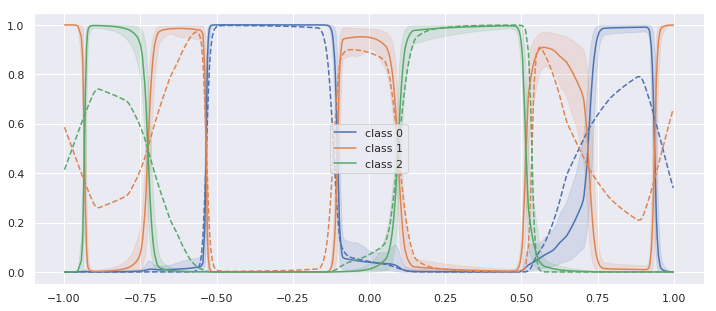

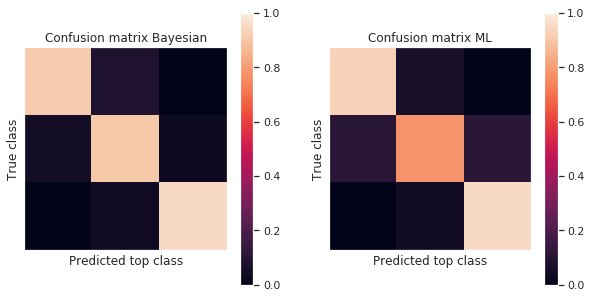

In [6]:
##### BAYESIAN MODEL

### Get classifier output for the whole dataset and for many samples of the last layer's weights
n_samples = 50       
with torch.no_grad():
    # Compute deterministic NN output
    h = features(x_test)
    cov_ab = flat_to_triangular(cov_ab_params)
    y_all = []
    for i in range(n_samples):
        # Sample last layer's weights from posterior q(a, b)
        ab_sample = stochastic(mu_ab, make_cholesky(logvar_ab, cov_ab))
        a, b = ab_sample[:-b_size], ab_sample[-b_size:]
        a = a.view(a_shape)
        b = b.unsqueeze(0)
        
        # Compute last layer output (the logits) with the weights just sampled
        y = h @ a + b    # shape: (N, n_classes)
        
        y_all.append(y.softmax(1).unsqueeze(0).cpu().numpy())

y_all = np.concatenate(y_all, axis=0)  # shape: (n_samples, N, n_classes)


### Get predictions (argmax) for all samples of weights (a,b)
pred_class = np.argmax(y_all, axis=-1)   # tensor of indices, shape (n_samples, N)
pred_class_onehot = onehot(pred_class)
pred_class_mean = pred_class_onehot.mean(0)   # shape (N, n_classes)
# pred_class_mean: for each input point a vector of size n_classes that sums to 1


### Get confusion matrix based on those samples
conf_matrix = np.zeros((n_classes, n_classes))
for i in range(N_test):
    conf_matrix[t_values_test[i]] += pred_class_mean[i]
conf_matrix /= conf_matrix.sum(1, keepdims=True)




##### ML MODEL

### Get classifier output for the whole dataset and for many samples of the last layer's weights
n_samples = 1       
with torch.no_grad():
    # Compute deterministic NN output
    h = ml_features(x_test)
    ml_y_all = []
    for i in range(n_samples):
        # Sample last layer's weights from posterior q(a, b)
        ab_sample = ml_mu_ab
        a, b = ab_sample[:-b_size], ab_sample[-b_size:]
        a = a.view(a_shape)
        b = b.unsqueeze(0)
        
        # Compute last layer output (the logits) with the weights just sampled
        y = h @ a + b    # shape: (N, n_classes)
        
        ml_y_all.append(y.softmax(1).unsqueeze(0).cpu().numpy())

ml_y_all = np.concatenate(ml_y_all, axis=0)  # shape: (n_samples, N, n_classes)


### Get predictions (argmax) for all samples of weights (a,b)
ml_pred_class = np.argmax(ml_y_all, axis=-1)   # tensor of indices, shape (n_samples, N)
ml_pred_class_onehot = onehot(ml_pred_class)
ml_pred_class_mean = ml_pred_class_onehot.mean(0)   # shape (N, n_classes)
# pred_class_mean: for each input point a vector of size n_classes that sums to 1


### Get confusion matrix based on those samples
ml_conf_matrix = np.zeros((n_classes, n_classes))
for i in range(N_test):
    ml_conf_matrix[t_values_test[i]] += ml_pred_class_mean[i]
ml_conf_matrix /= ml_conf_matrix.sum(1, keepdims=True)





###### PLOT STUFF

### Plot class probability outputs of the classifier (distribution over different samples of a,b)
y_lower = np.percentile(y_all, 5, axis=0)
y_upper = np.percentile(y_all, 95, axis=0)
y_mean = np.mean(y_all, axis=0)
ml_y_mean = np.mean(ml_y_all, axis=0)
x_numpy = x_test.detach().cpu().numpy().flatten()
plt.figure(figsize=(12, 5))
for c in range(n_classes):
    plot(x_numpy, y_mean[:, c], y_lower[:, c], y_upper[:, c], color=sns.color_palette()[c],
         alpha=0.15, title='90% interval of {} samples of (a, b)'.format(n_samples), xlabel='$x$', ylabel='$Pr(c | x, a, b)$', 
         label='class {}'.format(c))
    plot(x_numpy, ml_y_mean[:, c], color=sns.color_palette()[c], linestyle='--')
plt.show()


# ### Plot probability of selecting each class (argmax version of the previous plot) - maybe this is useless
# plt.figure(figsize=(12, 7))
# for c in range(n_classes):
#     plot(x_numpy, pred_class_mean[:, c], color=sns.color_palette()[c], title='prob of classification of {} samples of (a, b)'.format(n_samples), xlabel='$x$', ylabel='', 
#          label='class {}'.format(c))
# plt.show()


### Show confusion matrix
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(conf_matrix, vmin=0.0, vmax=1.0)
plt.colorbar()
plt.grid(False)
clean_curr_axes()
plt.title('Confusion matrix Bayesian')
plt.xlabel('Predicted top class')
plt.ylabel('True class')
plt.subplot(1, 2, 2)
plt.imshow(ml_conf_matrix, vmin=0.0, vmax=1.0)
plt.colorbar()
plt.grid(False)
clean_curr_axes()
plt.title('Confusion matrix ML')
plt.xlabel('Predicted top class')
plt.ylabel('True class')
plt.show()


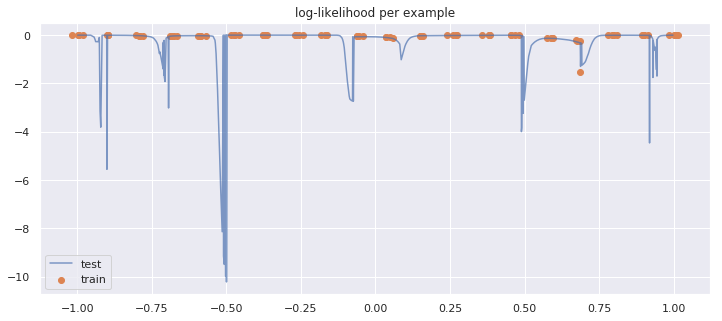

In [7]:
##### BAYESIAN MODEL

### Get classifier output for the whole dataset and for many samples of the last layer's weights
n_samples_test = 50
recons_test = torch.zeros((n_samples_test, x_test.size(0)), device=x.device)
recons = torch.zeros((n_samples_test, x.size(0)), device=x.device)
with torch.no_grad():
    # Compute deterministic NN output
    h = features(x_test)
    cov_ab = flat_to_triangular(cov_ab_params)
    y_all = []
    for i in range(n_samples_test):
        # Sample last layer's weights from posterior q(a, b)
        ab_sample = stochastic(mu_ab, make_cholesky(logvar_ab, cov_ab))
        a, b = ab_sample[:-b_size], ab_sample[-b_size:]
        a = a.view(a_shape)
        b = b.unsqueeze(0)
        
        # Compute last layer output (the logits) with the weights just sampled
        y = h @ a + b    # shape: (N, n_classes)
        
        recons_test[i] = f.cross_entropy(y, t_values_test, reduction='none')

    log_likelihood_test = (log_sum_exp(-recons_test, dim=0) - np.log(n_samples_test)).squeeze().detach().cpu().numpy()

    # Compute deterministic NN output
    h = features(x)
    cov_ab = flat_to_triangular(cov_ab_params)
    y_all = []
    for i in range(n_samples_test):
        # Sample last layer's weights from posterior q(a, b)
        ab_sample = stochastic(mu_ab, make_cholesky(logvar_ab, cov_ab))
        a, b = ab_sample[:-b_size], ab_sample[-b_size:]
        a = a.view(a_shape)
        b = b.unsqueeze(0)
        
        # Compute last layer output (the logits) with the weights just sampled
        y = h @ a + b    # shape: (N, n_classes)
        
        recons[i] = f.cross_entropy(y, t_values, reduction='none')

    log_likelihood = (log_sum_exp(-recons, dim=0) - np.log(n_samples_test)).squeeze().detach().cpu().numpy()

x_test_numpy = x_test.detach().cpu().numpy().flatten()
x_numpy = x.detach().cpu().numpy().flatten()
plt.figure(figsize=(12, 5))
plt.scatter(x_numpy, log_likelihood, label='train', color=sns.color_palette()[1])
plot(x_test_numpy, log_likelihood_test, title='log-likelihood per example', label='test', line_alpha=0.7)
plt.show()

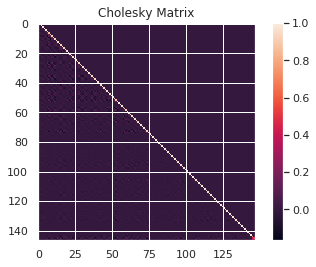

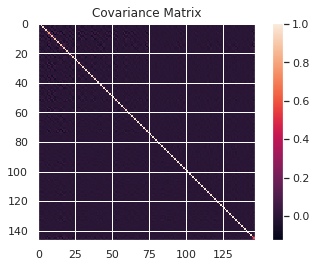

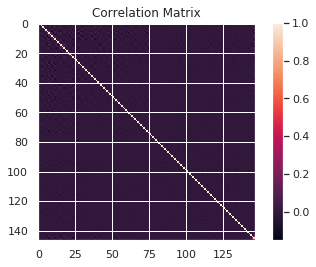

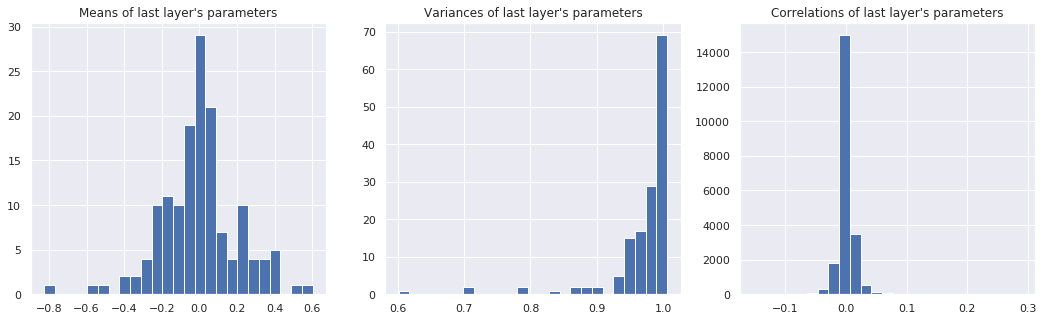

In [8]:
L = make_cholesky(logvar_ab, cov_ab).detach().cpu().numpy()
Cov = L @ L.T
inv_stds = np.diag(np.diag(Cov)**(-0.5))
Corr = inv_stds @ Cov @ inv_stds

plt.title("Cholesky Matrix")
plt.imshow(L)
plt.colorbar()
plt.show()

plt.title("Covariance Matrix")
plt.imshow(Cov)
plt.colorbar()
plt.show()

plt.title("Correlation Matrix")
plt.imshow(Corr)
plt.colorbar()
plt.show()

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.title("Means of last layer's parameters")
plt.hist(mu_ab.detach(), bins=25)
plt.subplot(1, 3, 2)
plt.title("Variances of last layer's parameters")
plt.hist(np.diag(Cov), bins=25)
plt.subplot(1, 3, 3)
plt.title("Correlations of last layer's parameters")  # corr coefficients between pairs of DIFFERENT variables
correlations = Corr[~np.eye(Corr.shape[0], dtype=bool)]
plt.hist(correlations, bins=25)
plt.show()